In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Detalles:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Detalles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier # ML Clasico
from sklearn.svm import SVC # por si acaso

In [3]:
BASE_DIR = r'C:\Users\oicas\OneDrive\Desktop\Intro a las App de Algoritmos de ML y DL\Proyecto\Dataset\dataset_proyecto_final'
IMG_SIZE = 224 #
BATCH_SIZE = 64 #32, 64 o 128
SEED = 42 #

In [4]:
def limpiar_imagenes(directorio):
    n_borradas = 0
    n_procesadas = 0    
    for root, dirs, files in os.walk(directorio):
        for file in files:
            ruta_img = os.path.join(root, file)
            try:
                img = cv2.imread(ruta_img) 
                if img is None:
                    print(f"[BORRADO] Imagen corrupta: {file}")
                    os.remove(ruta_img)
                    n_borradas += 1                
                n_procesadas += 1
                if n_procesadas % 100 == 0:
                    print(".", end="")                    
            except Exception as e:
                print(f"\n[ERROR] Fallo en {file}: {e}")
    print(f"Imágenes revisadas: {n_procesadas}")
    print(f"Imágenes borradas: {n_borradas}")
limpiar_imagenes(BASE_DIR)

..........................................................................................................................Imágenes revisadas: 12274
Imágenes borradas: 0


C:\Users\oicas\AppData\Local\Temp\ipykernel_19240\3051028997.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


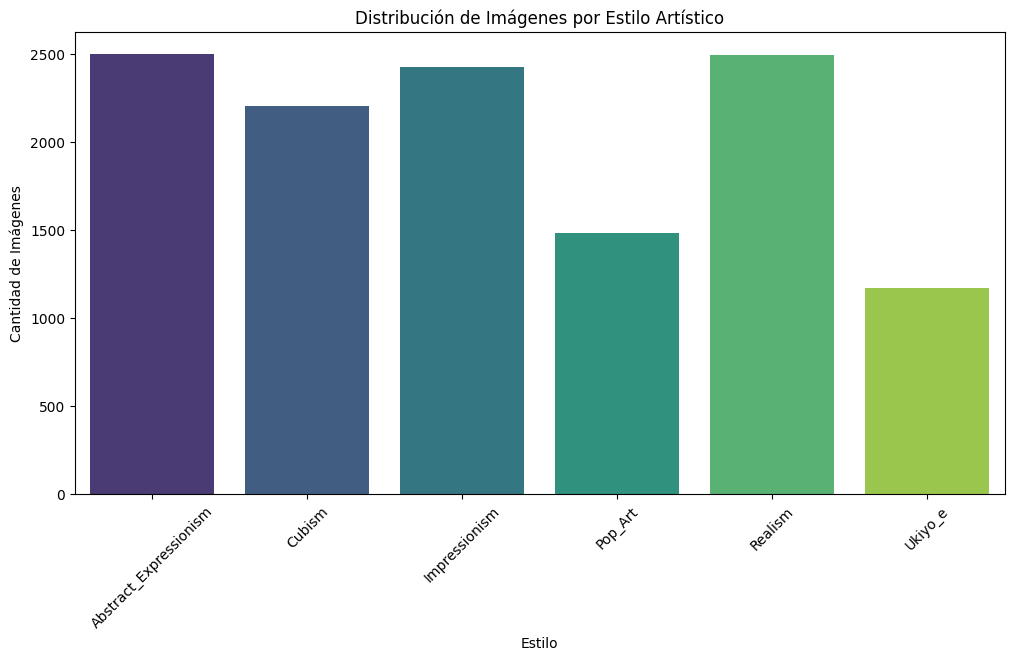

Total de clases: 6
Total de imágenes: 12274


In [5]:
classes = os.listdir(BASE_DIR)
counts = []

for c in classes:
    path = os.path.join(BASE_DIR, c)
    if os.path.isdir(path):
        counts.append(len(os.listdir(path)))

# visualizacion
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Distribución de Imágenes por Estilo Artístico")
plt.xlabel("Estilo")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=45)
plt.show()

print(f"Total de clases: {len(classes)}")
print(f"Total de imágenes: {sum(counts)}")

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,          
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], 
    channel_shift_range=20.0,    
    fill_mode='nearest',
    validation_split=0.2
)

# entrenamiento
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

# Generador de Validacion
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False # False para poder evaluar ordenadamente al final
)

class_names = list(train_generator.class_indices.keys())
print("Clases detectadas:", class_names)

Found 9822 images belonging to 6 classes.
Found 2452 images belonging to 6 classes.
Clases detectadas: ['Abstract_Expressionism', 'Cubism', 'Impressionism', 'Pop_Art', 'Realism', 'Ukiyo_e']


In [7]:
print("Extrayendo características con ResNet50V2 (sin entrenar) para ML Clásico...")

# cargar base ResNet sin la cabeza (top)
base_extractor = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = Sequential([
    base_extractor,
    GlobalAveragePooling2D()
])

# extraer características del conjunto de validación (para demostración rápida)
X_features = feature_extractor.predict(validation_generator)
y_labels = validation_generator.classes

# entrenar un clasificador clasico (Random Forest)
print("Entrenando Random Forest con características extraídas...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_features, y_labels)

# evaluar modelo clasico
acc_rf = rf_model.score(X_features, y_labels)
print(f"Accuracy del modelo Clásico (Random Forest + ResNet Features): {acc_rf:.2%}") #Este resultado sirve como base para comparar con la Red Neuronal completa

Extrayendo características con ResNet50V2 (sin entrenar) para ML Clásico...
39/39 [==============================] - 40s 910ms/step
Entrenando Random Forest con características extraídas...
Accuracy del modelo Clásico (Random Forest + ResNet Features): 100.00%


In [8]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.6), # Reduce overfitting
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                      

In [9]:
# Entrenamiento
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos calculados:", class_weights_dict)

# base congelada
base_model.trainable = False 

model.compile(optimizer=Adam(learning_rate=0.001), # LR normal
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Entrenamiento 1
history_stage_1 = model.fit(
    train_generator,
    epochs=17, 
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Pesos calculados: {0: 0.8185, 1: 0.9285309132161089, 2: 0.8429454170957775, 3: 1.37910699241786, 4: 0.8201402805611222, 5: 1.7526766595289078}
Epoch 1/17
154/154 [==============================] - 192s 1s/step - loss: 3.8700 - accuracy: 0.4519 - val_loss: 2.5090 - val_accuracy: 0.5999
Epoch 2/17
154/154 [==============================] - 189s 1s/step - loss: 2.2165 - accuracy: 0.5416 - val_loss: 1.8022 - val_accuracy: 0.6277
Epoch 3/17
154/154 [==============================] - 200s 1s/step - loss: 1.7659 - accuracy: 0.5697 - val_loss: 1.5543 - val_accuracy: 0.6195
Epoch 4/17
154/154 [==============================] - 202s 1s/step - loss: 1.5994 - accuracy: 0.5706 - val_loss: 1.4905 - val_accuracy: 0.5938
Epoch 5/17
154/154 [==============================] - 199s 1s/step - loss: 1.5219 - accuracy: 0.5696 - val_loss: 1.4423 - val_accuracy: 0.6069
Epoch 6/17
154/154 [==============================] - 192s 1s/step - loss: 1.4906 - accuracy: 0.5737 - val_loss: 1.3844 - val_accuracy: 0.6158

In [10]:
# Descongelar modelo 
base_model.trainable = True

# capas a entrenar
fine_tune_at = 140

# Congelar todas las capas anteriores
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), # mucho mas lento y preciso
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Callbacks
early_stop_fine = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint_fine = ModelCheckpoint('modelo_arte_finetuned.keras', save_best_only=True, monitor='val_accuracy')

# entrenar de nuevo
# total_epochs sera la suma de la etapa 1 + etapa 2
total_epochs = 17 + 23 

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_stage_1.epoch[-1], # Continuar
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop_fine, checkpoint_fine]
)

Epoch 17/40
154/154 [==============================] - 200s 1s/step - loss: 1.4059 - accuracy: 0.5936 - val_loss: 1.3280 - val_accuracy: 0.6191
Epoch 18/40
154/154 [==============================] - 200s 1s/step - loss: 1.2977 - accuracy: 0.6321 - val_loss: 1.2747 - val_accuracy: 0.6423
Epoch 19/40
154/154 [==============================] - 203s 1s/step - loss: 1.2177 - accuracy: 0.6623 - val_loss: 1.2349 - val_accuracy: 0.6603
Epoch 20/40
154/154 [==============================] - 193s 1s/step - loss: 1.1754 - accuracy: 0.6667 - val_loss: 1.2087 - val_accuracy: 0.6603
Epoch 21/40
154/154 [==============================] - 194s 1s/step - loss: 1.1318 - accuracy: 0.6837 - val_loss: 1.1773 - val_accuracy: 0.6729
Epoch 22/40
154/154 [==============================] - 195s 1s/step - loss: 1.0969 - accuracy: 0.7005 - val_loss: 1.1695 - val_accuracy: 0.6766
Epoch 23/40
154/154 [==============================] - 191s 1s/step - loss: 1.0578 - accuracy: 0.7131 - val_loss: 1.1571 - val_accuracy:

Text(0, 0.5, 'Accuracy')

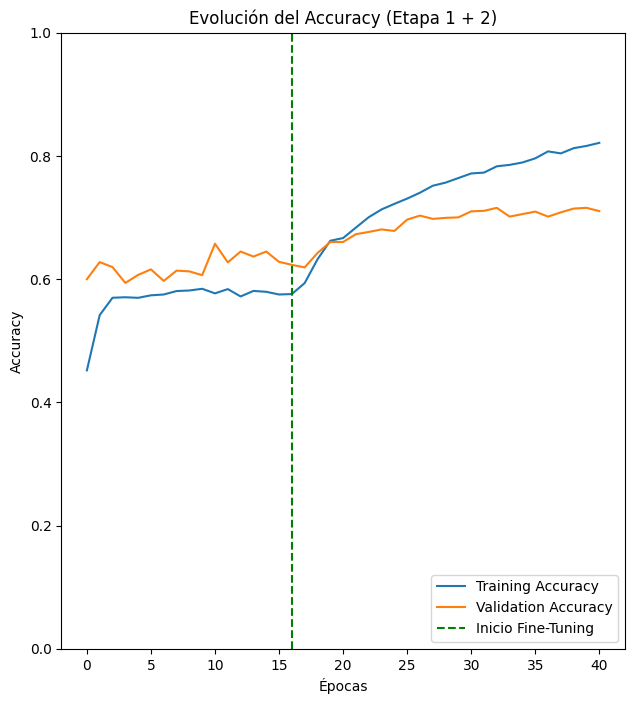

In [11]:
acc = history_stage_1.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_stage_1.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history_stage_1.history['loss'] + history_fine.history['loss']
val_loss = history_stage_1.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(16, 8))

# graffica de Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
# Dibujar línea vertical donde empezó el Fine-Tuning
initial_epochs = len(history_stage_1.history['accuracy'])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Inicio Fine-Tuning', color='green', linestyle='--')
plt.legend(loc='lower right')
plt.title('Evolución del Accuracy (Etapa 1 + 2)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')

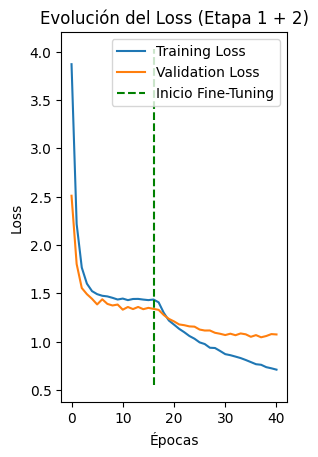

In [12]:
# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Dibujar línea vertical
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Inicio Fine-Tuning', color='green', linestyle='--')
plt.legend(loc='upper right')
plt.title('Evolución del Loss (Etapa 1 + 2)')
plt.xlabel('Épocas')
plt.ylabel('Loss')

plt.show()

39/39 [==============================] - 36s 916ms/step


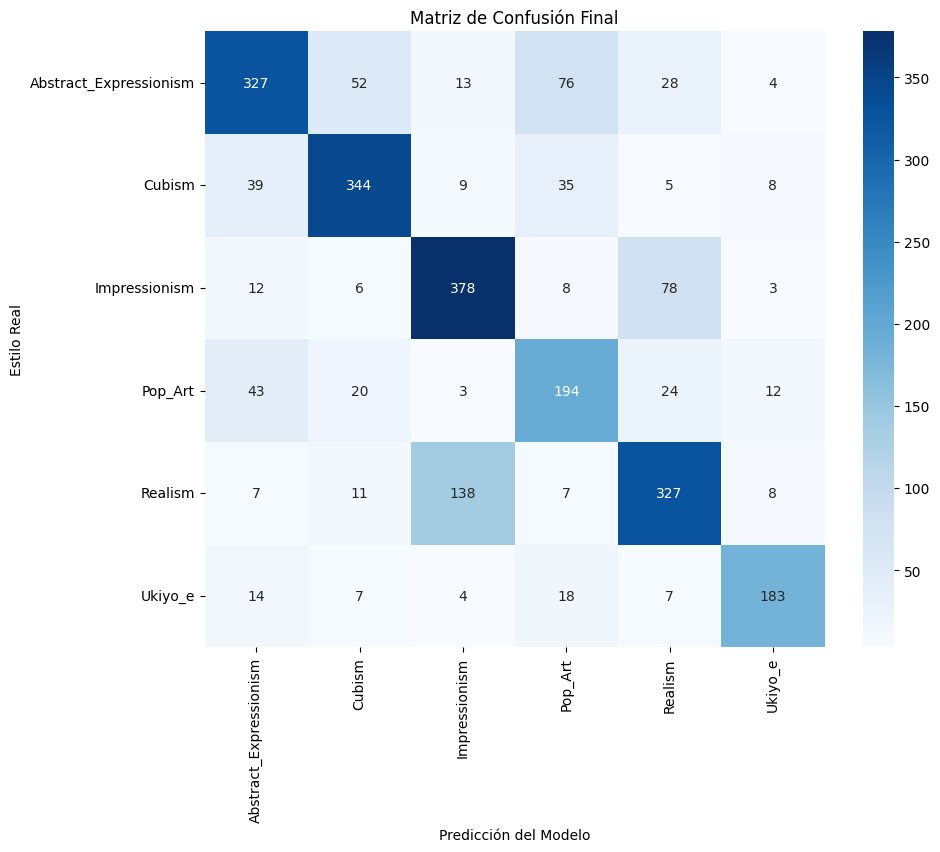

In [13]:
validation_generator.reset() # Reiniciar generador para asegurar orden
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1) # Convertir probabilidades a etiquetas
y_true = validation_generator.classes   # Etiquetas reales

# matriz
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Estilo Real')
plt.title('Matriz de Confusión Final')
plt.show()

In [14]:
# Reporte de Clasificación
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_true, y_pred, target_names=class_names))


Reporte de Clasificación Detallado:
                        precision    recall  f1-score   support

Abstract_Expressionism       0.74      0.65      0.69       500
                Cubism       0.78      0.78      0.78       440
         Impressionism       0.69      0.78      0.73       485
               Pop_Art       0.57      0.66      0.61       296
               Realism       0.70      0.66      0.68       498
               Ukiyo_e       0.84      0.79      0.81       233

              accuracy                           0.71      2452
             macro avg       0.72      0.72      0.72      2452
          weighted avg       0.72      0.71      0.72      2452



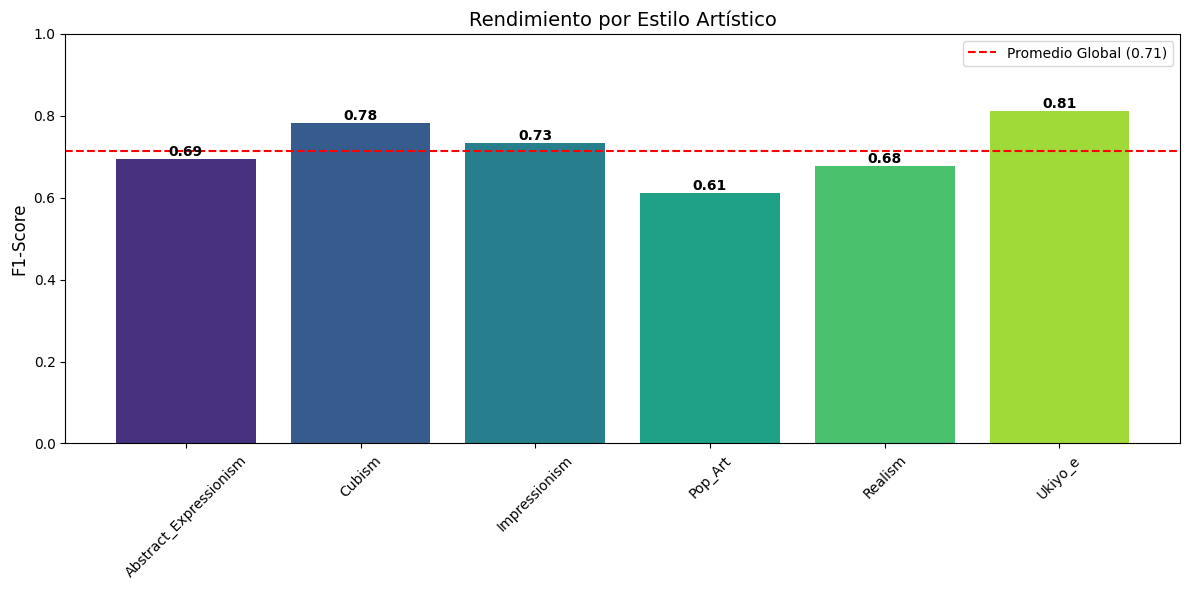


Tabla de Métricas Exactas:


,precision,recall,f1-score,support
Abstract_Expressionism,0.739819,0.654000,0.694268,500.0
Cubism,0.781818,0.781818,0.781818,440.0
Impressionism,0.693578,0.779381,0.733981,485.0
Pop_Art,0.573964,0.655405,0.611987,296.0
Realism,0.697228,0.656627,0.676319,498.0
Ukiyo_e,0.839450,0.785408,0.811530,233.0


In [15]:
# diccionario
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# DataFrame para filtrar fácil
df_report = pd.DataFrame(report_dict).transpose()
df_estilos = df_report.loc[class_names]

estilos = df_estilos.index
f1_scores = df_estilos['f1-score']

plt.figure(figsize=(12, 6))
colores = sns.color_palette("viridis", len(estilos))
bars = plt.bar(estilos, f1_scores, color=colores)
plt.ylim(0, 1.0)
plt.title('Rendimiento por Estilo Artístico', fontsize=14)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=45) # Rotar nombres si son muy largos

# promedio
acc_global = report_dict['accuracy']
plt.axhline(y=acc_global, color='r', linestyle='--', label=f'Promedio Global ({acc_global:.2f})')
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTabla de Métricas Exactas:")
display(df_estilos[['precision', 'recall', 'f1-score', 'support']])